# Exploratory Analysis on Start Up Data
This dataset was pulled from Kaggle
https://www.kaggle.com/khaiid/startups-by-valuation

I will perform some exploratory analysis on this dataset and answer some basic questions.

## Prerequisites

In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import regex as re
from bs4 import BeautifulSoup

In [3]:
dataset = pd.read_csv(r"C:\Users\manik\Desktop\Grayce\Start-up Data Analysis Projec\Startups.csv")

In [4]:
dataset

,Company,Valuation,Valuation_date,Industry,Country
0,ByteDance,140.00,April-21,Internet,China
1,SpaceX,100.00,October-21,Aerospace,United States
2,Stripe,95.00,March-21,Financial services,United States / Ireland
3,Klarna,45.60,June-21,Fintech,Sweden
4,Canva,40.00,September-21,Graphic design,Australia
...,...,...,...,...,...
245,Bitso,2.20,May-21,Cryptocurrency,Mexico
246,Gympass,2.20,June-21,NaN,Brazil / United States
247,Kurly,2.20,July-21,E-commerce,South Korea
248,Addepar,2.17,June-21,Fintech,United States


# Inspection of datasets

In [5]:
dataset.info() #Valuation date -> datatime and Missing values in Industry

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company         250 non-null    object 
 1   Valuation       250 non-null    float64
 2   Valuation_date  250 non-null    object 
 3   Industry        233 non-null    object 
 4   Country         250 non-null    object 
dtypes: float64(1), object(4)
memory usage: 9.9+ KB


<AxesSubplot:>

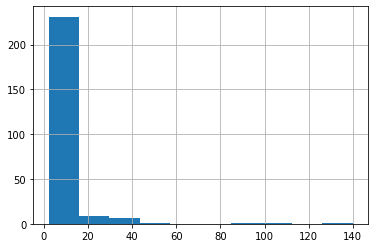

In [6]:
dataset['Valuation'].hist() #There seems to be no issues, majority companies tend to be valued between 0-15 billion

In [7]:
dataset[dataset['Valuation']>40] #No issues in terms of outliers for valuation

,Company,Valuation,Valuation_date,Industry,Country
0,ByteDance,140.0,April-21,Internet,China
1,SpaceX,100.0,October-21,Aerospace,United States
2,Stripe,95.0,March-21,Financial services,United States / Ireland
3,Klarna,45.6,June-21,Fintech,Sweden


In [8]:
dataset[dataset['Valuation']<5] #Again no issues with quick glance at lower end

,Company,Valuation,Valuation_date,Industry,Country
106,Meesho,4.90,September-21,E-commerce,India
107,Bolt,4.75,August-21,Transportation,Estonia
108,Anduril Industries,4.60,June-21,Defense Technology,United States
109,Checkr,4.60,August-21,NaN,United States
110,Dataiku,4.60,August-21,Artificial intelligence,France / United States
...,...,...,...,...,...
245,Bitso,2.20,May-21,Cryptocurrency,Mexico
246,Gympass,2.20,June-21,NaN,Brazil / United States
247,Kurly,2.20,July-21,E-commerce,South Korea
248,Addepar,2.17,June-21,Fintech,United States


In [9]:
dataset['Industry'].value_counts(dropna=False)

Fintech                      24
Software                     23
NaN                          17
E-commerce                   15
Artificial intelligence      10
                             ..
Financial Technology          1
Electronic Cigarettes         1
Consumer electronics          1
Content management system     1
Personal finance              1
Name: Industry, Length: 82, dtype: int64

In [10]:
dataset['Valuation_date'].value_counts() #There are no issues with the valuation dates (seem to all be in a reasonable range)

June-21         31
August-21       29
July-21         19
September-21    18
October-21      18
May-21          17
April-21        14
November-21     14
March-21        11
January-21       9
December-20      7
October-20       5
February-21      4
November-19      4
December-21      3
October-16       3
January-19       3
August-20        2
March-20         2
November-16      2
October-19       2
June-18          2
September-19     2
November-20      2
July-19          2
April-17         1
November-18      1
February-20      1
May-19           1
June-20          1
September-15     1
February-14      1
September-18     1
June-17          1
May-15           1
September-16     1
February-19      1
May-20           1
September-17     1
December-19      1
July-20          1
February-18      1
February-16      1
August-18        1
October-14       1
October-18       1
November-17      1
June-19          1
December-16      1
May-18           1
Name: Valuation_date, dtype: int64

In [11]:
dataset['Country'].value_counts() #There are two United States & Two India / US

 United States                      87
  United States                     27
 India                              21
 China                              21
 United Kingdom                      7
 Canada                              6
  India                              6
 Germany                             5
  China                              5
  United Kingdom                     4
 Brazil                              3
 France                              3
  South Korea                        3
 South Korea                         3
 Israel /  United States             3
  Indonesia                          2
 Turkey                              2
  France                             2
 Netherlands                         2
 China /  United States              2
 Sweden                              2
 Israel                              2
 Portugal /  United States           2
  France /   United States           1
 Hong Kong /  China                  1
  Vietnam                

In [12]:
boolean = dataset['Country']=='United States'
dataset[boolean] #Upon inspecting the original csv file, Country seems to includes &nbsp and most likely the source of two US being present

,Company,Valuation,Valuation_date,Industry,Country


# Data Cleaning
* We need to convert Valuation_date to datetime - Done
* Upon a little research Country seems to have two types:
    * There are two countries listed in the form (Founded)/(HQ) (This needs to be split up) - Done
    * Or both are the same and only one country is listed - Done
* Industry is very granulated, must aggregate this up - Done
* There are missing industries for 17 companies - Done
* Clean up &nbsp in Country column - Done

## Removing &NBSP issue by splitting up Founded and HQ

In [13]:
dataset['Founded'] = dataset['Country'].str.extract(r'(\w+\s?\w+)\/?')

In [14]:
dataset['Founded'].value_counts()

United States     115
China              29
India              29
United Kingdom     13
France              7
Israel              7
South Korea         6
Canada              6
Germany             6
Brazil              4
Australia           3
Indonesia           3
Mexico              2
Sweden              2
Portugal            2
Netherlands         2
Turkey              2
Belgium             2
Argentina           2
Colombia            1
Lithuania           1
Bahamas             1
Hong Kong           1
Austria             1
Estonia             1
Vietnam             1
Japan               1
Name: Founded, dtype: int64

In [15]:
dataset['HQ'] = dataset['Country'].str.extract(r'\/\s+(\w+\s?\w+)')

In [16]:
dataset

,Company,Valuation,Valuation_date,Industry,Country,Founded,HQ
0,ByteDance,140.00,April-21,Internet,China,China,NaN
1,SpaceX,100.00,October-21,Aerospace,United States,United States,NaN
2,Stripe,95.00,March-21,Financial services,United States / Ireland,United States,Ireland
3,Klarna,45.60,June-21,Fintech,Sweden,Sweden,NaN
4,Canva,40.00,September-21,Graphic design,Australia,Australia,NaN
...,...,...,...,...,...,...,...
245,Bitso,2.20,May-21,Cryptocurrency,Mexico,Mexico,NaN
246,Gympass,2.20,June-21,NaN,Brazil / United States,Brazil,United States
247,Kurly,2.20,July-21,E-commerce,South Korea,South Korea,NaN
248,Addepar,2.17,June-21,Fintech,United States,United States,NaN


In [17]:
if dataset['HQ'].isnull:
    dataset['HQ']=dataset['Founded']

In [18]:
dataset

,Company,Valuation,Valuation_date,Industry,Country,Founded,HQ
0,ByteDance,140.00,April-21,Internet,China,China,China
1,SpaceX,100.00,October-21,Aerospace,United States,United States,United States
2,Stripe,95.00,March-21,Financial services,United States / Ireland,United States,United States
3,Klarna,45.60,June-21,Fintech,Sweden,Sweden,Sweden
4,Canva,40.00,September-21,Graphic design,Australia,Australia,Australia
...,...,...,...,...,...,...,...
245,Bitso,2.20,May-21,Cryptocurrency,Mexico,Mexico,Mexico
246,Gympass,2.20,June-21,NaN,Brazil / United States,Brazil,Brazil
247,Kurly,2.20,July-21,E-commerce,South Korea,South Korea,South Korea
248,Addepar,2.17,June-21,Fintech,United States,United States,United States


In [19]:
dataset['HQ'].value_counts()

United States     115
China              29
India              29
United Kingdom     13
France              7
Israel              7
South Korea         6
Canada              6
Germany             6
Brazil              4
Australia           3
Indonesia           3
Mexico              2
Sweden              2
Portugal            2
Netherlands         2
Turkey              2
Belgium             2
Argentina           2
Colombia            1
Lithuania           1
Bahamas             1
Hong Kong           1
Austria             1
Estonia             1
Vietnam             1
Japan               1
Name: HQ, dtype: int64

## Convert Valuation_date to Datetime

In [20]:
dataset['Valuation_date'] = pd.to_datetime(dataset['Valuation_date'], format = '%B-%y')

In [21]:
dataset

,Company,Valuation,Valuation_date,Industry,Country,Founded,HQ
0,ByteDance,140.00,2021-04-01,Internet,China,China,China
1,SpaceX,100.00,2021-10-01,Aerospace,United States,United States,United States
2,Stripe,95.00,2021-03-01,Financial services,United States / Ireland,United States,United States
3,Klarna,45.60,2021-06-01,Fintech,Sweden,Sweden,Sweden
4,Canva,40.00,2021-09-01,Graphic design,Australia,Australia,Australia
...,...,...,...,...,...,...,...
245,Bitso,2.20,2021-05-01,Cryptocurrency,Mexico,Mexico,Mexico
246,Gympass,2.20,2021-06-01,NaN,Brazil / United States,Brazil,Brazil
247,Kurly,2.20,2021-07-01,E-commerce,South Korea,South Korea,South Korea
248,Addepar,2.17,2021-06-01,Fintech,United States,United States,United States


## Aggregating Industry

In [22]:
dataset['Industry'].value_counts()

Fintech                      24
Software                     23
E-commerce                   15
Artificial intelligence      10
Cryptocurrency                9
                             ..
Data governance               1
Electronic Cigarettes         1
Consumer electronics          1
Content management system     1
Personal finance              1
Name: Industry, Length: 81, dtype: int64

In [23]:
agg_map = {
    'Software': ['Software industry', 'Software development', 'Computer software', 'Collaborative software', 'Software as a service', 'Software'],
    'Media & Socials': ['Mass media', 'Internet media', 'Messaging'],
    'Fintech': ['Financial Technology', 'Fintech'],
    'Computing':['Computer storage', 'Quantum computing', 'Semiconductors', 'Cybersecurity'],
    'Health & Hospitality': ['Hospitality', 'Health', 'Healthcare'],
    'Other Technology': ['Wearable technology', 'Robotic process automation', 'Educational technology', 'Education Technology','Defense Technology', 'Augmented Reality', 'Robotics', 'Health technology', 'Technology', 'Education technology', 'Real estate technology', 'Consumer electronics', 'Internet', 'Flexible electronics', 'Cloud communications'],
    'Crypto': ['NFT', 'Blockchain', 'Cryptocurrency'],
    'Data': ['Data analytics', 'Data governance', 'Data storage', 'Data infrastructure'],
    'Finance': ['Personal finance', 'Venture capital', 'Insurance', 'Finance', 'Financial services'],
    'Sales & Marketing': ['Sales', 'Marketing'],
    'E-Commerce': ['B2B e-commerce', 'Marketplace', 'E-commerce'],
    'Automotive': ['Electric vehicles', 'Self-driving cars'],
    'Video Games': ['Video games', 'Mobile gaming'],
    'Transport': ['Transportation', 'Logistics', 'Trucking','Aerospace'],
    'IT Security': ['Cloud security', 'Application security', 'Computer security'],
    'Design & Art': ['Graphic design','Interior design'],
    'Business': ['CRM', 'Content management system','Human resource management', 'Workforce management'],
    'Artificial intelligence': ['Artificial intelligence'],
    'Other': ['Electronic Cigarettes', 'Food delivery', 'Real estate', 'Batteries', 'Identity management', 'Home improvement', 'Real Estate', 'Ghost kitchen', 'Virtual events', 'Education', 'Fantasy sports', 'Retail', 'Travel']}

In [24]:
map = {}
for i in agg_map:
    value = agg_map[i]
    for c in value:
        map[c] = i

In [25]:
dataset['Industry_Updated'] = dataset['Industry'].map(map, na_action='ignore')

In [26]:
dataset['Industry_Updated'].value_counts()

Software                   30
Other Technology           29
Fintech                    25
E-Commerce                 23
Other                      21
Finance                    17
Crypto                     13
Transport                  13
Computing                  12
Artificial intelligence    10
Health & Hospitality        7
Video Games                 6
Business                    6
Automotive                  5
Data                        4
Sales & Marketing           4
Media & Socials             3
IT Security                 3
Design & Art                2
Name: Industry_Updated, dtype: int64

In [27]:
boolean = dataset['Industry'].isnull()
dataset[boolean]

,Company,Valuation,Valuation_date,Industry,Country,Founded,HQ,Industry_Updated
29,GoodLeap,12.00,2021-10-01,NaN,United States,United States,United States,NaN
97,Thrasio,5.00,2021-10-01,NaN,United States,United States,United States,NaN
109,Checkr,4.60,2021-08-01,NaN,United States,United States,United States,NaN
134,Patreon,4.00,2021-04-01,NaN,United States,United States,United States,NaN
143,VAST Data,3.70,2021-05-01,NaN,United States,United States,United States,NaN
145,Shouqi,3.55,2016-12-01,NaN,China,China,China,NaN
170,SentinelOne,3.10,2020-11-01,NaN,United States,United States,United States,NaN
195,VANCL,3.00,2014-02-01,NaN,China,China,China,NaN
198,Wefox,3.00,2021-06-01,NaN,Germany,Germany,Germany,NaN
199,Yixia Technology,3.00,2016-11-01,NaN,China,China,China,NaN


In [28]:
# Using google to fill in blanks
null_update = ['Fintech', 'Business', 'Business', 'Business', 'Data', 'Automotive', 'IT Security', 'E-Commerce', 'Fintech', 'Other Technology', 'Finance', 'Software', 'Other', 'E-Commerce', 'Artificial intelligence', 'Other', 'Other']

dataset.loc[boolean, 'Industry_Updated'] = null_update

In [29]:
dataset['Industry_Updated'].value_counts(dropna=False)

Software                   31
Other Technology           30
Fintech                    27
E-Commerce                 25
Other                      24
Finance                    18
Crypto                     13
Transport                  13
Computing                  12
Artificial intelligence    11
Business                    9
Health & Hospitality        7
Video Games                 6
Automotive                  6
Data                        5
Sales & Marketing           4
IT Security                 4
Media & Socials             3
Design & Art                2
Name: Industry_Updated, dtype: int64

All data cleaning is complete
# Exploratory Data Analysis
## What is the most popular Industry for start up companies?

<AxesSubplot:>

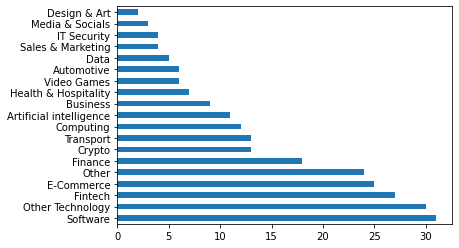

In [30]:
num_by_industry = dataset['Industry_Updated'].value_counts()
num_by_industry.plot(kind = 'barh')

It seems that start-ups are more commonly opening in IT related industries for example Software, Tech and Fintech being the top three.

## Which industry provides the most value?
I am going to use Valuation as a measure of the company's value

In [31]:
total_value_by_industry = dataset.pivot_table(values = 'Valuation', columns = 'Industry_Updated', aggfunc = 'sum').melt().set_index(keys = 'Industry_Updated').sort_values(by = 'value')

<AxesSubplot:ylabel='Industry_Updated'>

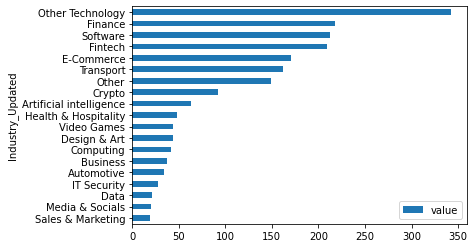

In [32]:
total_value_by_industry.plot(kind = 'barh')

Unsuprisingly, the top 4 highest valued industries are tech related. This is somewhat in line with the top 4 industries with the largest number of start ups.

In [33]:
merged = pd.merge(left = total_value_by_industry, right = num_by_industry, how = 'inner', left_index= True, right_index= True)
merged.corr()

,value,Industry_Updated
value,1.000000,0.900835
Industry_Updated,0.900835,1.000000


This shows that there is a very high correlation between the number of start ups within the industry and the total value of the industry. However it is important to note that there may be no causal relationship as it is possible that the number of start up causes the overall value of the industry to be large or the opposite where large valued industry causes more start ups to occur in that industry.
However the main point is that there is a positive strong correlation between both variables.

<AxesSubplot:ylabel='Industry_Updated'>

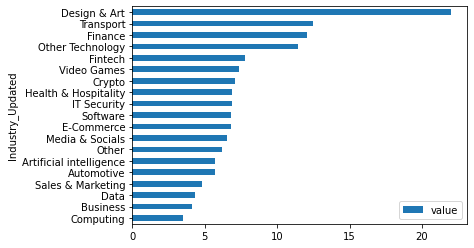

In [34]:
avg_value_by_industry = dataset.pivot_table(values = 'Valuation', columns = 'Industry_Updated', aggfunc = 'mean').melt().set_index(keys = 'Industry_Updated').sort_values(by = 'value')
avg_value_by_industry.plot(kind = 'barh')

In [35]:
merged_2 = pd.merge(left = avg_value_by_industry, right = num_by_industry, how = 'inner', left_index= True, right_index= True)
merged_2.corr()

,value,Industry_Updated
value,1.000000,0.001906
Industry_Updated,0.001906,1.000000


Looking at average value, there seems to be no correlation between average value by industry and the number of startups by industry. Surprisingly Design & Art came out on top by a long way. There are two possibilities for this, there is a small sample size for Design & Art startups thus leading to skewed statistics or the low sample size may mean that the existing startups are in an oligopoly allowing them to enjoy larger piece of the overall market thus leading to large average valuations in that industry.

## How does country of HQ play into this?

Surpringly, Sweden came out on top with t

<AxesSubplot:>

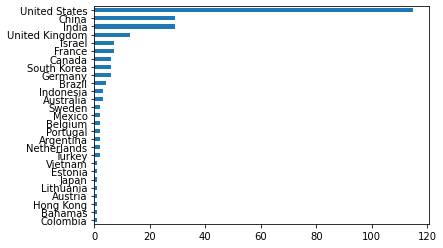

In [36]:
dataset['HQ'].value_counts(ascending=True).plot(kind='barh')

The top 4 are US, China, India and UK. These are all countries who are deemed economically well off. All these countries are within the top 6 economies in the in regards to GDP. Interestingly the order matches that of the top 4 with Japan and Germany being placed in between India and UK. Another fact is that these economies provide major incentives to start ups hence why there are in the top 4. Compared to countries like Japan who have only recently started rolling out incentives for startups.
Surpringsly, Germany does not perform too well in the number of startups. This is surprising because Germany's economy is larger than the UK and also is deemed more startup friendly compared to the UK

<AxesSubplot:ylabel='HQ'>

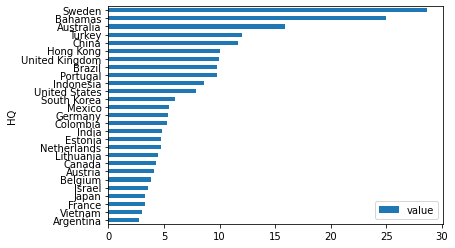

In [37]:
dataset.pivot_table(values = 'Valuation', columns = 'HQ', aggfunc = 'mean').melt().set_index(keys = 'HQ').sort_values(by = 'value').plot(kind = 'barh')

The top 4 countries with the largest average valuation are countries with very small amount of startups. As mentioned before this might by due to very small sample size or the small amount of large startup leading to firms enjoying an imperfectly competitive market.
However it would seem, out of the largest economies, China seems to have the largest average valuation so as a startup it may be beneficial to start up a company in China.

## How does country of Founding play into this?

<AxesSubplot:>

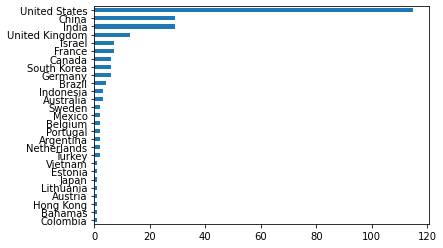

In [38]:
dataset['Founded'].value_counts(ascending=True).plot(kind='barh')

Unsurpringly, this seems to show an almost identical pattern to the question posed before with slight variation in the lower ranking countries. This is most likely because countries found in a country is most likely to locate their HQ in the same country

<AxesSubplot:ylabel='Founded'>

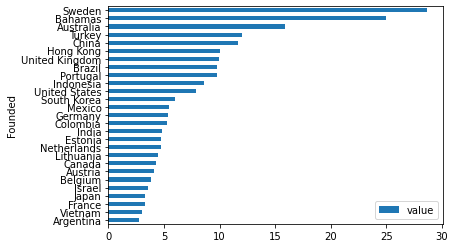

In [40]:
dataset.pivot_table(values = 'Valuation', columns = 'Founded', aggfunc = 'mean').melt().set_index(keys = 'Founded').sort_values(by = 'value').plot(kind = 'barh')

Again there seems to be no variation as again the most compelling reason is that countries founded in a region is likely to stay in the same region. However this does show that most startups do not tend to relocate upon growing to a larger size.